.param C22=4.895e-09 C21=5.105e-09 C3=1.000e-08 R1=5.538e+02 Rb=5.600e+02 R41=3.650e+03 Ra1=1.472e+04 Ra2=3.536e+04 R42=5.570e+04
C3 = 10.000 n
C22 = 4.895 n
C21 = 5.105 n
Ra1 = 14.715 K
Ra2 = 35.364 K
R1 = 553.811 
R42 = 55.705 K
R41 = 3.650 K
Rb = 560.000 

SQ = 2.00000   w0 = 2.00000   wz = 2.60693  {'Q0': 1.243512533263495, 'n2': 0.5, 'Rb': 560, 'C': 1e-08}

H = (0.5*s**2 - 2.27373675443232e-12*s + 258148277.5328)/(1.0*s**2 + 48654.9512354986*s + 5271289993.3225)
\frac{0.5 s^{2} - 2.27373675443232 \cdot 10^{-12} s + 258148277.5328}{1.0 s^{2} + 48654.9512354986 s + 5271289993.3225}


<Figure size 640x480 with 0 Axes>

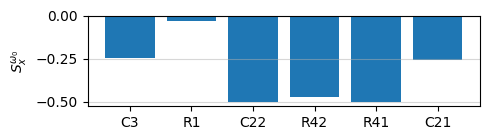

<Figure size 640x480 with 0 Axes>

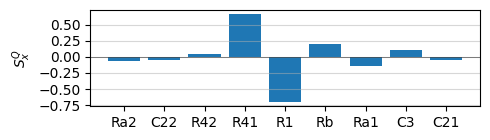

<Figure size 640x480 with 0 Axes>

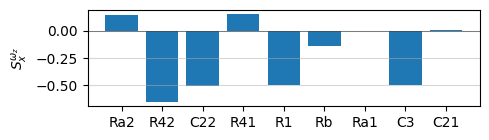

C_{3} -2.45E-01
R_{1} -3.07E-02
C_{22} -5.00E-01
R_{42} -4.69E-01
R_{41} -5.00E-01
C_{21} -2.55E-01


In [3]:
from SedraHPB import SedraHPB
import sympy as sp
import numpy as np

# Create a SedraHPB object
wzero = 22722.16 # rad/s
wpole = 72603.65
Q = 1.492215039916194


sedra = SedraHPB(w0=wpole, Q=Q, wz=wzero)
n2_sedra = 0.5

def iterate(values={}):
    sedra.setDesignParams(Q0=values["Q0"], n2=values["n2"])

    sedra.setBaseComponentValues(Rb=values["Rb"], C=values["C"])

    sedra.computeDesignParams()
    sedra.computeComponentValues()
    H, s = sedra.getTransferFunction()
    
    sedra.calculateSensTables(ponderar=False)
    sedra.printSpiceParams()
    sedra.printEngineeringFormatParams()
    print(f"\nSQ = {sedra.Q_sen_sum:.5f}   w0 = {sedra.w0_sen_sum:.5f}   wz = {sedra.wz_sen_sum:.5f}  " + str(values))
    return H, s


H, s = iterate({"Q0": Q/1.2, "n2": n2_sedra, "Rb": 560, "C": 10e-9, })

# display(H)
print("\nH =", H)
print(sp.latex(H))
# sedra.printSpiceParams()

from plot_utils import plotSensTable, save_pdf
plotSensTable(sedra.w0_table, sedra.w0_labels, ylabel="$S^{{\\omega_0}}_{{x}}$")
plotSensTable(sedra.Q_table, sedra.Q_labels, ylabel="$S^{{Q}}_{{x}}$")
plotSensTable(sedra.wz_table, sedra.wz_labels, ylabel="$S^{{\\omega_z}}_{{x}}$")

for Sw0, label in zip(sedra.w0_table, sedra.w0_labels): 
    print(sp.latex(sp.Symbol(label)), f"{Sw0:.2E}")

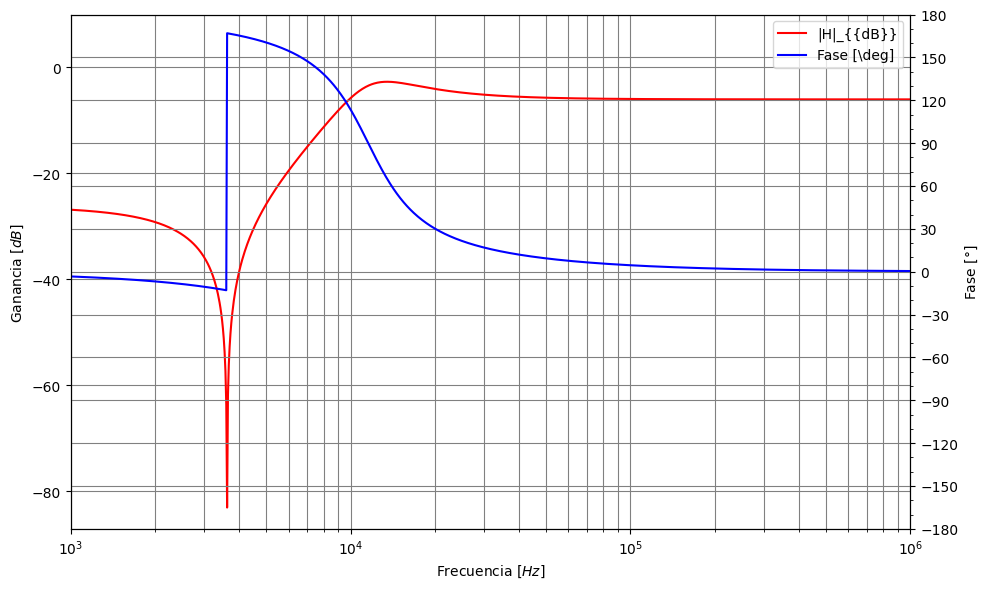

In [4]:
from sympy_utils import sympy_to_tf, sympy_format_polynomial
from plot_utils import PlotBode

f_log = np.logspace(3, 6, 1000)
htf = sympy_to_tf(H, s)
bode = PlotBode()
bode.plotTransfer(htf, f=f_log)
bode.show()

In [14]:
from RCHiPass import RCHiPass

w0_real = 97728.866
target_n2 = 9.1067e-01
hipass = RCHiPass(w0=w0_real, k=target_n2/n2_sedra)
hipass.setBaseComponents(C=0.1e-9, Rb=5600)
hipass.printComponentValues()
hipass.printEngineeringFormatParams()
H_1st, s = hipass.getTransferFunction(s)

display(H_1st)
print(H_1st)
H_total = sympy_format_polynomial(H * H_1st, s)
# show the complete polynomial
print()
display(H_total)
print(H_total)

.param C = 1.000e-10 R = 1.023e+05 Ra = 4.600e+03 Rb2 = 5.600e+03
C = 100.00p
R = 102.32k
Ra = 4.60k
Rb2 = 5.60k


1.82134*s/(s + 97728.866)

1.82134*s/(s + 97728.866)



(0.91067*s**3 - 4.14124770031776e-12*s**2 + 470175783.801589*s)/(1.0*s**3 + 146383.817235499*s**2 + 10026283202.8531*s + 515157193404555.0)

(0.91067*s**3 - 4.14124770031776e-12*s**2 + 470175783.801589*s)/(1.0*s**3 + 146383.817235499*s**2 + 10026283202.8531*s + 515157193404555.0)


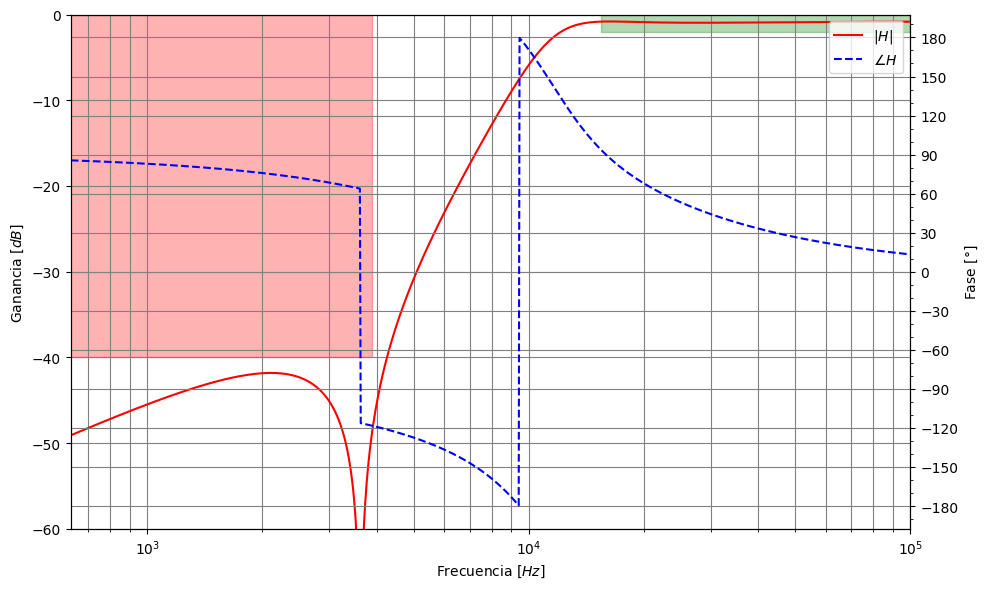

In [6]:
from scipy import signal
fp = 15500 # Passband frequency in Hz
fa = 3875 # Stopband frequency in Hz

Ap = 2 # Passband attenuation in dB
Aa = 40 # Stopband attenuation in dB

f_log = np.logspace(2.8, 5, 1000)
w_log = 2 * np.pi * f_log

htf = sympy_to_tf(H_total, s)
# get frequency response
_, hresp = signal.freqresp(htf, w_log)

bode = PlotBode()
bode.plotSemilog1(f_log, 20*np.log10(np.abs(hresp)), color='red', label='$|H|$')
bode.plotSemilog2(f_log, np.angle(hresp, deg=True), color='blue', label='$\\angle H$', linestyle='--')
bode.drawRectangle1(1e2, fa, -Aa, 0, color='red', alpha=0.3)
bode.drawRectangle1(fp, 1e5, -Ap, 0, color='green', alpha=0.3)
bode.show(y1limits=[-60, 0])